# Isochrone

In [1]:
import os
os.environ['HTTP_PROXY']=""
os.environ['HTTPS_PROXY']=""

## Isochrone with osmnx

In [2]:
import geopandas as gpd
from shapely.geometry import Point
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt
from descartes import PolygonPatch
ox.config(log_console=True, use_cache=True)

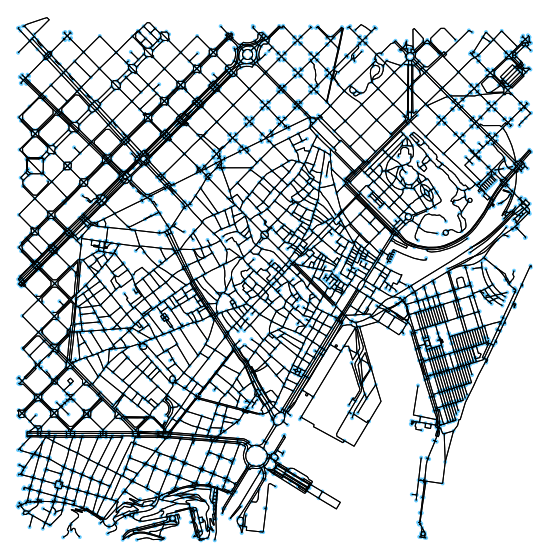

(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a5b44d0608>)

In [3]:
Barcelona_network = ox.graph_from_address("Barcelona, Spain", dist=1500, simplify=True, network_type="walk")
ox.plot_graph(Barcelona_network, fig_height=10, fig_width=10, edge_color="black")

In [4]:
Barcelona_nodes = ox.graph_to_gdfs(Barcelona_network, edges=False)
point = ox.get_nearest_node(Barcelona_network, point=(41.3834656,2.1764566))
Barcelona_nodes = ox.project_graph(Barcelona_network)

trip_times = [2, 5, 10, 20] # timepo en minutos
travel_speed = 60
meters_per_minute = travel_speed * 1000 / 60
for u, v, k, data in Barcelona_network.edges(data=True, keys=True):
    data['time'] = data['length'] / meters_per_minute

In [5]:
isochrone_polys = []
for trip_time in sorted(trip_times, reverse=True):
    subgraph = nx.ego_graph(Barcelona_nodes, point, radius=trip_time, distance='time')
    node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
    bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
    isochrone_polys.append(bounding_poly)

gdf = gpd.GeoDataFrame({"time": trip_times}, geometry= isochrone_polys)
gdf.crs = {'init': 'epsg:32631'}
gdf.to_crs({'init': 'epsg:4326'}, inplace=True)
gdf.head()

,time,geometry
0,2,"POLYGON ((2.17807 41.37566, 2.17172 41.37789, ..."
1,5,"POLYGON ((2.17668 41.37992, 2.17534 41.38041, ..."
2,10,"POLYGON ((2.17585 41.38167, 2.17546 41.38188, ..."
3,20,"POLYGON ((2.17667 41.38261, 2.17565 41.38329, ..."


In [6]:
import folium 

#color=[]
m = folium.Map([41.3834656,2.1764566], zoom_start=15, tiles='CartoDB positron')
#for row in dfsample.itertuples():
folium.GeoJson(gdf, style_function=lambda feature: {
        'fillColor': 'green',    
        'color' : 'black',
        'weight' : 1,
        'fillOpacity' : 0.3,
        }).add_to(m)
m
#m.save("C://Users//vzaldo//Desktop//isochrone_ox.html")

## Isochrone with CARTO

In [7]:
from cartoframes.auth import set_default_credentials
set_default_credentials('E://Code//ipynb//03_GIS//Carto//creds.json')

In [8]:
from geopandas import GeoDataFrame, points_from_xy
from cartoframes.data.services import Isolines

gdf2 = GeoDataFrame([['Barcelona', 2.1764566, 41.3834656],],columns=['address', 'lng', 'lat'])
gdf2.set_geometry(points_from_xy(gdf2['lng'], gdf2['lat']), inplace=True)
iso_service = Isolines()
isochrones_gdf, isochrones_metadata = iso_service.isochrones(gdf2, [120, 300, 600, 1200], mode='walk', exclusive=True)
isochrones_gdf.head()

Success! Isolines created correctly


,source_id,data_range,lower_data_range,the_geom,range_label
0,0,120,0,"MULTIPOLYGON (((2.17626 41.38439, 2.17622 41.3...",2 min.
1,0,300,120,"POLYGON ((2.17623 41.38588, 2.17656 41.38563, ...",5 min.
2,0,600,300,"POLYGON ((2.17614 41.38914, 2.17685 41.38909, ...",10 min.
3,0,1200,600,"POLYGON ((2.17498 41.39520, 2.17778 41.39493, ...",20 min.


In [10]:
from cartoframes.viz import Map, Layer
Map([Layer(isochrones_gdf, 'color: opacity(green, 0.3)'),Layer(gdf2, 'width: 3')])